# Task 3.3 Transpile and Optimize Circuits

## Objective 1 : Transpiler stages

1. Initialization
2. Layout
3. Routing
4. Translation
5. Optimization
6. Scheduling

1. Initialization stage is used to include customized optimizations and updates gates that use more than 2 qubits in one and two qubit gates

2. Layout stage is used to map from virtual to physical qubits on the backend that will be used

minimize the number of SWAPs , 
2 passes : find a perfect layout without swaps then a herustic layout
    * TrivialLayout and then  VF2Layout
    * DenseLayout and then SabreLayout

3. Routing stage is used to find the minimum number of swaps required implment SabreSwap

Text(0, 0.5, 'Counts')

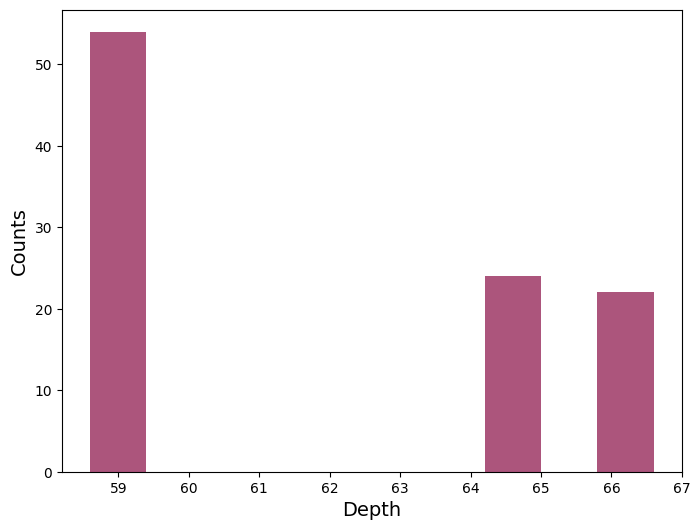

In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeAuckland, FakeWashingtonV2
from qiskit.transpiler import generate_preset_pass_manager
 
backend = FakeAuckland()
 
ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))
 
depths = []
for seed in range(100):
    pass_manager = generate_preset_pass_manager(
        optimization_level=1,
        backend=backend,
        layout_method="trivial",  # Fixed layout mapped in circuit order
        seed_transpiler=seed,  # For reproducible results
    )
    depths.append(pass_manager.run(ghz).depth())
 
plt.figure(figsize=(8, 6))
plt.hist(depths, align="left", color="#AC557C")
plt.xlabel("Depth", fontsize=14)
plt.ylabel("Counts", fontsize=14)

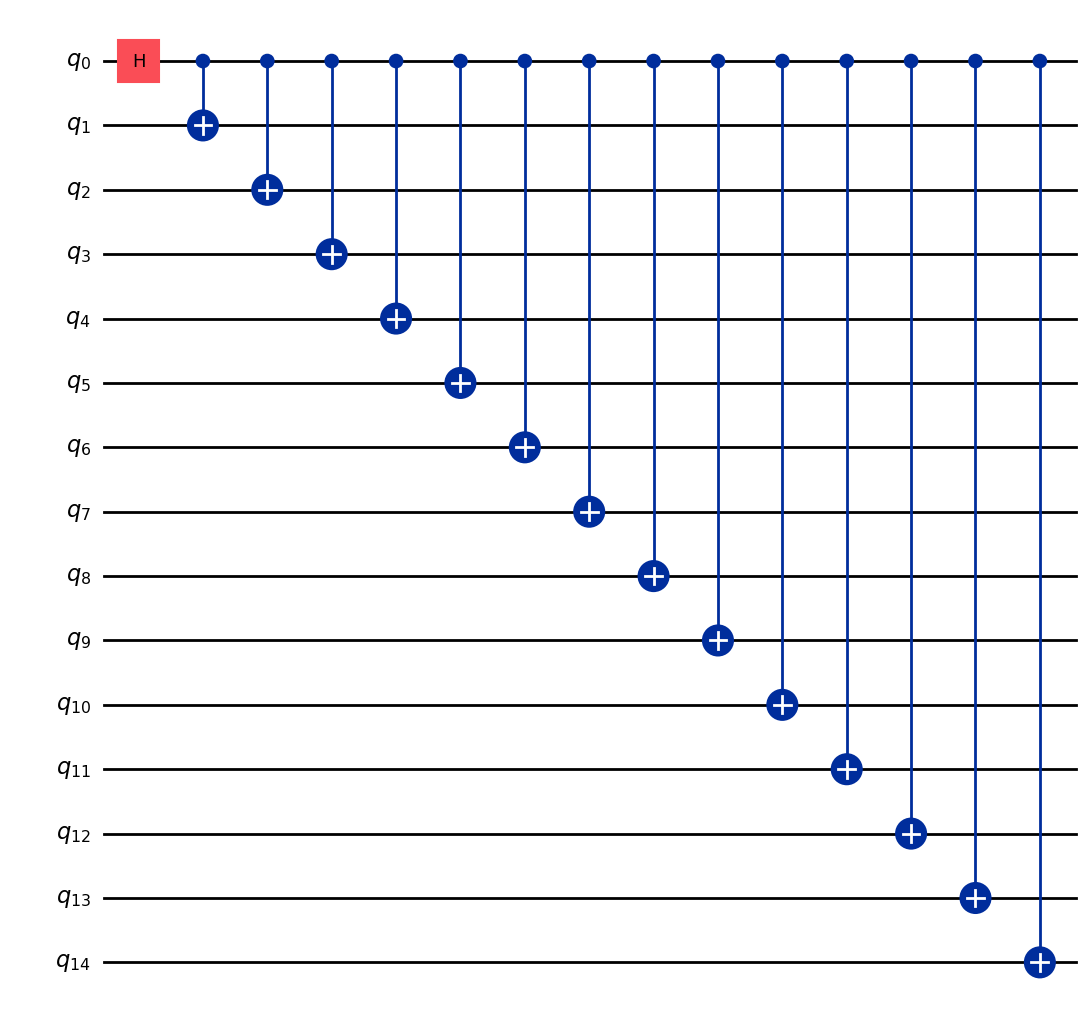

In [2]:
ghz.draw("mpl", idle_wires=False)

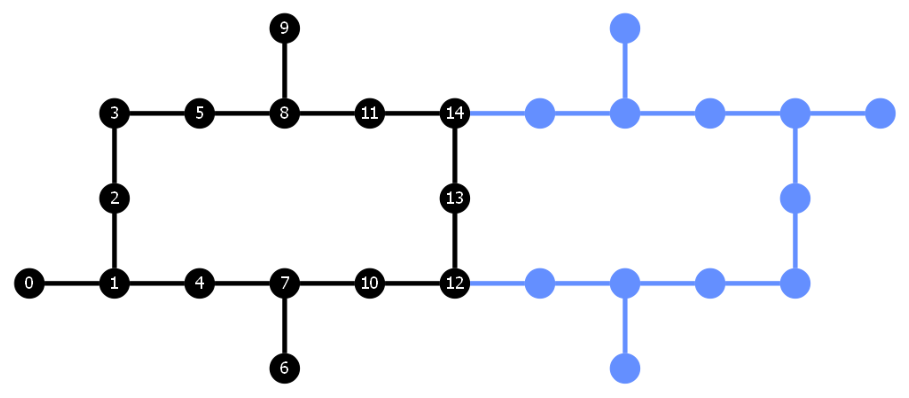

In [3]:
from qiskit.visualization import plot_circuit_layout
 
# Plot the hardware graph and indicate which hardware qubits were chosen to run the circuit
transpiled_circ = pass_manager.run(ghz)
plot_circuit_layout(transpiled_circ, backend)

4. Translation stage translate the gates in teh circuit to the native basis gates 

native gates:['cx', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']


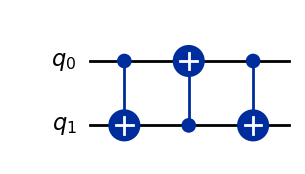

In [4]:
print("native gates:" + str(sorted(backend.operation_names)))
qc = QuantumCircuit(2)
qc.swap(0, 1)
qc.decompose().draw("mpl")

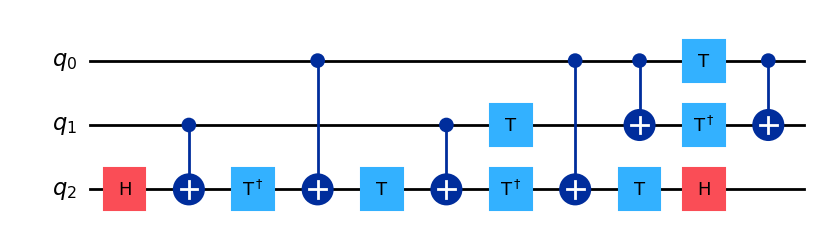

In [5]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.decompose().draw("mpl")

5. Optimization stage is used decrase the depth of the circuit
uses different optimization levels

* optimization_level=1 , Uses Optimize1qGatesDecomposition and CXCancellation
* optimization_level=2 , Uses CommutativeCancellation
* optimization_level=3 , Uses Collect2qBlocks, ConsolidateBlocks, UnitarySynthesis, Optimize1qGateDecomposition , CommutativeCancellation



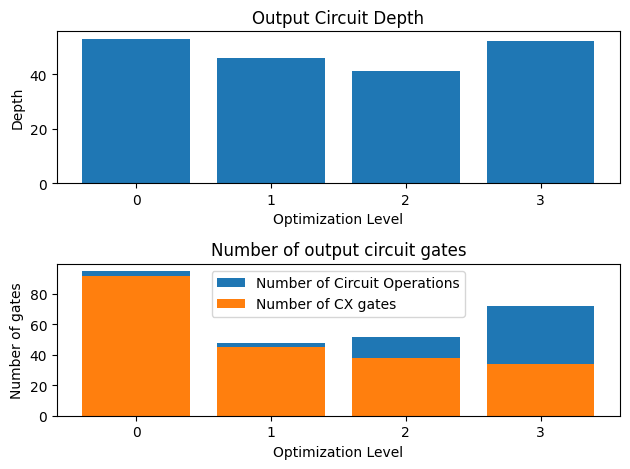

In [6]:
ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))
 
depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=backend,
        seed_transpiler=1234,
    )
    circ = pass_manager.run(ghz)
    depths.append(circ.depth())
    gate_counts.append(sum(circ.count_ops().values()))
    multiqubit_gate_counts.append(circ.count_ops()["cx"])
 
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label="Number of Circuit Operations")
ax2.bar(levels, multiqubit_gate_counts, label="Number of CX gates")
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
plt.show()

6. Scheduling stage does not run by default like initialization , used to account to all idle times of the circuit
insers delays instructions to account for idle times and inspect how long the circuit will run on the backend

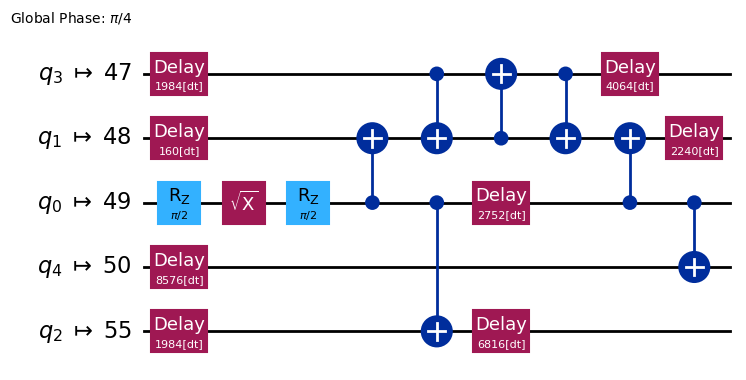

In [7]:
ghz = QuantumCircuit(5)
ghz.h(0)
ghz.cx(0, range(1, 5))
 
 
# Use fake backend
backend = FakeWashingtonV2()
 
# Run with optimization level 3 and 'asap' scheduling pass
pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    scheduling_method="asap",
    seed_transpiler=1234,
)
 
 
circ = pass_manager.run(ghz)
circ.draw(output="mpl", idle_wires=False)

## Objective 2: Transpile with Pass Managers

A Pass Manager is an object that stores all transpiler passes and executes them when its run method is called.

Staged Pass Manager is the abstraction level above the pass manager , staged pass manager is composed of a several pass managers

In [ ]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

C:\QC\venvs\sandbox\.venv\Lib\site-packages\qiskit_ibm_runtime\api\auth.py:67: UserWarning: Unable to retrieve IBM Cloud access token. API Key will be used instead. HTTPSConnectionPool(host='iam.cloud.ibm.com', port=443): Max retries exceeded with url: /identity/token (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000022C4FC93A10>: Failed to resolve 'iam.cloud.ibm.com' ([Errno 11001] getaddrinfo failed)"))
  warnings.warn(


RequestsApiError: 'HTTPSConnectionPool(host=\'us-east.quantum-computing.cloud.ibm.com\', port=443): Max retries exceeded with url: /backends (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000022C52C60050>: Failed to resolve \'us-east.quantum-computing.cloud.ibm.com\' ([Errno 11001] getaddrinfo failed)"))'

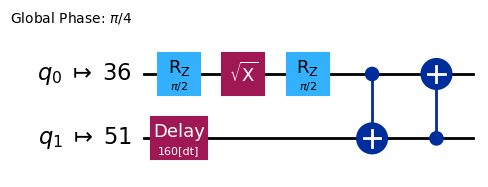

In [ ]:
from qiskit import QuantumRegister, QuantumCircuit
 
# Create a circuit
qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)
a, b = qubits
circuit.h(a)
circuit.cx(a, b)
circuit.cx(b, a)
 
# Transpile it by calling the run method of the pass manager
transpiled = pass_manager.run(circuit)
 
# Draw it, excluding idle qubits from the diagram
transpiled.draw("mpl", idle_wires=False)

In [ ]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnitarySynthesis,
)
 
basis_gates = ["rx", "ry", "rxx"]
translate = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

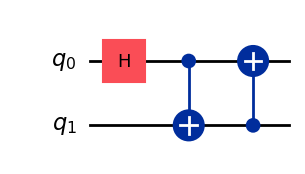

In [ ]:
from qiskit import QuantumRegister, QuantumCircuit
 
qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)
 
a, b = qubits
circuit.h(a)
circuit.cx(a, b)
circuit.cx(b, a)
 
circuit.draw("mpl")

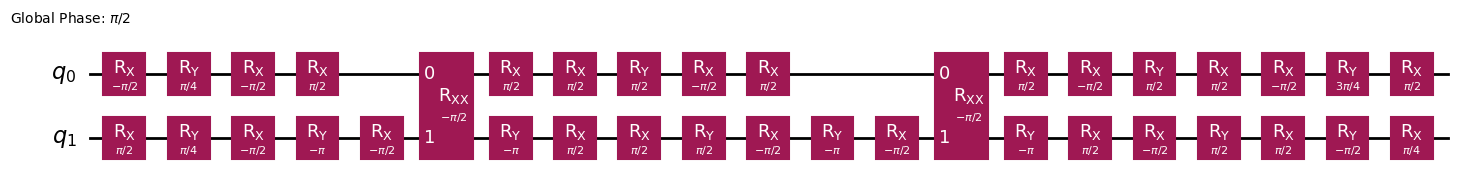

In [ ]:
translated = translate.run(circuit)
translated.draw("mpl")

In [ ]:
from qiskit.transpiler import PassManager, StagedPassManager
from qiskit.transpiler.passes import UnitarySynthesis, Unroll3qOrMore
 
basis_gates = ["rx", "ry", "rxx"]
init = PassManager(
    [UnitarySynthesis(basis_gates, min_qubits=3), Unroll3qOrMore()]
)
staged_pm = StagedPassManager(
    stages=["init", "translation"], init=init, translation=translate
)

In [ ]:
import numpy as np
from qiskit.circuit.library import HGate, PhaseGate, RXGate, TdgGate, TGate
from qiskit.transpiler.passes import InverseCancellation
 
pass_manager = generate_preset_pass_manager(3, backend)
inverse_gate_list = [
    HGate(),
    (RXGate(np.pi / 4), RXGate(-np.pi / 4)),
    (PhaseGate(np.pi / 4), PhaseGate(-np.pi / 4)),
    (TGate(), TdgGate()),
]
logical_opt = PassManager(
    [
        InverseCancellation(inverse_gate_list),
    ]
)
 
# Add pre-layout stage to run extra logical optimization
pass_manager.pre_layout = logical_opt

## Objective 3 Transpiler Passes

Layout Selection

* TrivialLayout: Choose a Layout by assigning n circuit qubits to device qubits 0, .., n-1.
* DenseLayout: Choose a Layout by finding the most connected subset of qubits.
* SabreLayout: Choose a Layout via iterative bidirectional routing of the input circuit.
* CSPLayout: If possible, chooses a Layout as a CSP, using backtracking.
* VF2Layout: A pass for choosing a Layout of a circuit onto a Coupling graph, as a subgraph isomorphism problem, solved by VF2++.
* ApplyLayout: Transform a circuit with virtual qubits into a circuit with physical qubits.
* Layout2qDistance: Evaluate how good the layout selection was.
* EnlargeWithAncilla: Extend the dag with virtual qubits that are in layout but not in the circuit yet.
* FullAncillaAllocation: Allocate all idle nodes from the coupling map or target as ancilla on the layout.
* SabrePreLayout: Choose a starting layout to use for additional Sabre layout trials.

Routing

* BasicSwap: Map (with minimum effort) a DAGCircuit onto a coupling_map adding swap gates.
* Commuting2qGateRouter: A class to swap route one or more commuting gates to the coupling map.
* LayoutTransformation: Adds a Swap circuit for a given (partial) permutation to the circuit.
* LookaheadSwap: Map input circuit onto a backend topology via insertion of SWAPs.
* SabreSwap: Map input circuit onto a backend topology via insertion of SWAPs.
* StarPreRouting: Run star to linear pre-routing

Basis Change

* BasisTranslator: Translates gates to a target basis by searching for a set of translations from a given EquivalenceLibrary.
* Decompose: Expand a gate in a circuit using its decomposition rules.
* TranslateParameterizedGates: Translate parameterized gates to a supported basis set.
* Unroll3qOrMore: Recursively expands 3q+ gates until the circuit only contains 2q or 1q gates.
* UnrollCustomDefinitions: Unrolls instructions with custom definitions.

Optimizations:

* Collect1qRuns: Collect one-qubit subcircuits.
* Collect2qBlocks: Collect two-qubit subcircuits.
* CollectAndCollapse: A general transpiler pass to collect and to consolidate blocks of nodes in a circuit.
* CollectCliffords: Collects blocks of Clifford gates and replaces them by a Clifford object.
* CollectLinearFunctions: Collect blocks of linear gates (CXGate and SwapGate gates) and replaces them by linear functions (LinearFunction).
* CollectMultiQBlocks: Collect sequences of uninterrupted gates acting on groups of qubits.
* CommutationAnalysis: Analysis pass to find commutation relations between DAG nodes.
* CommutativeCancellation: Cancel the redundant (self-adjoint) gates through commutation relations.
* CommutativeInverseCancellation: Cancel pairs of inverse gates exploiting commutation relations.
* ConsolidateBlocks: Replace each block of consecutive gates by a single Unitary node.
* ContractIdleWiresInControlFlow: Remove idle qubits from control-flow operations of a DAGCircuit.
* ElidePermutations: Remove permutation operations from a pre-layout circuit
* HoareOptimizer: This is a transpiler pass using Hoare logic circuit optimization.
* InverseCancellation: Cancel specific Gates which are inverses of each other when they occur back-to- back.
* Optimize1qGates: Optimize chains of single-qubit u1, u2, u3 gates by combining them into a single gate.
* Optimize1qGatesDecomposition: Optimize chains of single-qubit gates by combining them into a single gate.
* Optimize1qGatesSimpleCommutation: Optimizes 1Q gate strings interrupted by 2Q gates by commuting the components and resynthesizing the results.
* OptimizeAnnotated: Optimization pass on circuits with annotated operations.
* OptimizeCliffordT: An optimization pass for Clifford+T circuits.
* OptimizeCliffords: Combine consecutive Cliffords over the same qubits.
* OptimizeSwapBeforeMeasure: Remove the swaps followed by measurement (and adapt the measurement).
* RemoveDiagonalGatesBeforeMeasure: Remove diagonal gates (including diagonal 2Q gates) before a measurement.
* RemoveFinalReset: Remove reset when it is the final instruction on a qubit wire.
* RemoveIdentityEquivalent: Remove gates with negligible effects.
* RemoveResetInZeroState: Remove reset gate when the qubit is in zero state.
* ResetAfterMeasureSimplification: This pass replaces reset after measure with a conditional X gate.
* Split2QUnitaries: Attempt to splits two-qubit unitaries in a DAGCircuit into two single-qubit gates.
* TemplateOptimization: Class for the template optimization pass.

Scheduling

* ALAPScheduleAnalysis: ALAP Scheduling pass, which schedules the stop time of instructions as late as possible.
* ASAPScheduleAnalysis: ASAP Scheduling pass, which schedules the start time of instructions as early as possible.
* ConstrainedReschedule: Rescheduler pass that updates node start times to conform to the hardware alignments.
* ContextAwareDynamicalDecoupling: Implement an X-sequence dynamical decoupling considering the gate- and qubit-context.
* InstructionDurationCheck: Duration validation pass for reschedule.
* PadDelay: Padding idle time with Delay instructions.
* PadDynamicalDecoupling: Dynamical decoupling insertion pass.
* SetIOLatency: Set IOLatency information to the input circuit.
* TimeUnitConversion: Choose a time unit to be used in the following time-aware passes, and make all circuit time units consistent with that.


Circuit Analysis

* CountOps: Count the operations in a DAG circuit.
* CountOpsLongestPath: Count the operations on the longest path in a DAGCircuit.
* DAGLongestPath: Return the longest path in a DAGCircuit as a list of DAGOpNodes, DAGInNodes, and DAGOutNodes.
* Depth: Calculate the depth of a DAG circuit.
* NumTensorFactors: Calculate the number of tensor factors of a DAG circuit.
* ResourceEstimation: Automatically require analysis passes for resource estimation.
* Size: Calculate the size of a DAG circuit.
* Width: Calculate the width of a DAG circuit.

Synthesis

* HLSConfig: The high-level-synthesis config allows to specify a list of "methods" used by HighLevelSynthesis transformation pass to synthesize different types of higher-level objects.
* HighLevelSynthesis: Synthesize higher-level objects and unroll custom definitions.
* LinearFunctionsToPermutations: Promotes linear functions to permutations when possible.
* SolovayKitaev: Approximately decompose 1q gates to a discrete basis using the Solovay-Kitaev algorithm.
* UnitarySynthesis: Synthesize gates according to their basis gates.

Post Layout

* VF2PostLayout: A pass for improving an existing Layout after transpilation of a circuit onto a Coupling graph, as a subgraph isomorphism problem, solved by VF2++.

Additional Passes

* BarrierBeforeFinalMeasurements: Add a barrier before final measurements.
* CheckGateDirection: Check if the two-qubit gates follow the right direction with respect to the coupling map.
* CheckMap: Check if a DAG circuit is already mapped to a coupling map.
* ContainsInstruction: An analysis pass to detect if the DAG contains a specific instruction.
* DAGFixedPoint: Check if the DAG has reached a fixed point.
* Error: Error pass to be called when an error happens.
* FilterOpNodes: Remove all operations that match a filter function
* FixedPoint: Check if a property reached a fixed point.
* GateDirection: Modify asymmetric gates to match the hardware coupling direction.
* GatesInBasis: Check if all gates in a DAG are in a given set of gates
* MergeAdjacentBarriers: Return a circuit with any adjacent barriers merged together.
* MinimumPoint: Check if the DAG has reached a relative semi-stable point over previous runs
* RemoveBarriers: Return a circuit with any barrier removed.
* RemoveFinalMeasurements: Remove final measurements and barriers at the end of a circuit.
* UnrollForLoops: UnrollForLoops transpilation pass unrolls for-loops when possible.